# Reproduction of the paper of Weitz et al.

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

### Figure 1

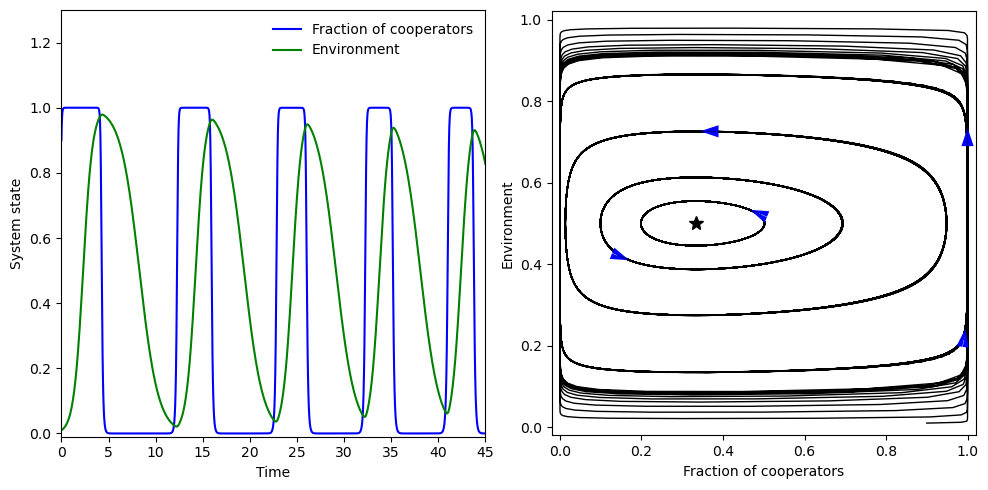

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def dynamics_symmetric(t, y, epsilon, theta, R, S, T, P):
    x, n = y
    
    # --- FIX: Clip variables to avoid numerical explosion ---
    x = np.clip(x, 0, 1)
    n = np.clip(n, 0, 1)
    # --------------------------------------------------------

    delta_PS = P - S
    delta_TR = T - R
    payoff_term = (1.0 - 2.0 * n) * (delta_PS + (delta_TR - delta_PS) * x)
    
    dxdt = (1.0 / epsilon) * x * (1.0 - x) * payoff_term
    dndt = n * (1.0 - n) * (-1.0 + (1.0 + theta) * x)
    
    return [dxdt, dndt]
def reproduce_figure_2():
    # Parameters from Weitz et al. 2016
    epsilon = 0.1
    theta = 2.0
    R, S, T, P = 3.0, 0.0, 5.0, 1.0

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # --- LEFT PANEL: Time Series ---
    # LSODA handles the "square wave" shape well
    sol = solve_ivp(dynamics_symmetric, (0, 45), [0.9, 0.01], 
                    t_eval=np.linspace(0, 45, 1000),
                    method='RK45',
                    args=(epsilon, theta, R, S, T, P),
                    max_step=0.1,    # Prevents jagged corners
                    rtol=1e-5,       # High precision relative
                    atol=1e-8)      # High precision absolute (Crucial!)
    
    ax = axes[0]
    ax.plot(sol.t, sol.y[0], 'b-', label='Fraction of cooperators')
    ax.plot(sol.t, sol.y[1], 'g-', label='Environment')
    ax.set_xlabel('Time')
    ax.set_ylabel('System state')
    ax.set_xlim(0, 45)
    ax.set_ylim(-0.01, 1.3)
    ax.legend(loc='upper right', frameon=False)

    # --- RIGHT PANEL: Phase Plane ---
    ax = axes[1]
    initial_conditions = [(0.9, 0.01), (0.8, 0.15), (0.7, 0.3), (0.5, 0.4), (0.4, 0.45)]
    
    for ic in initial_conditions:
        # Loop closure is very sensitive to tolerance here
        sol_orbit = solve_ivp(dynamics_symmetric, (0, 100), ic, 
                              t_eval=np.linspace(0, 100, 1000), # Smooth plotting
                              args=(epsilon, theta, R, S, T, P),
                              max_step=0.1,
                              rtol=1e-5, 
                              atol=1e-8) 
        
        ax.plot(sol_orbit.y[0], sol_orbit.y[1], 'k-', lw=1.0)
        
        # Add Arrows
        idx = len(sol_orbit.t) // 4
        x_curr, n_curr = sol_orbit.y[0][idx], sol_orbit.y[1][idx]
        dx, dn = dynamics_symmetric(0, [x_curr, n_curr], epsilon, theta, R, S, T, P)
        norm = np.hypot(dx, dn)
        ax.arrow(x_curr, n_curr, dx/norm*0.001, dn/norm*0.001, 
                 shape='full', lw=0, length_includes_head=True, 
                 head_width=0.03, color='blue', zorder=5)

    # Plot Fixed Point 
    fixed_x = 1.0 / (1.0 + theta)
    fixed_n = 0.5
    ax.plot(fixed_x, fixed_n, 'k*', markersize=10)

    ax.set_xlabel('Fraction of cooperators')
    ax.set_ylabel('Environment')
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

reproduce_figure_2()

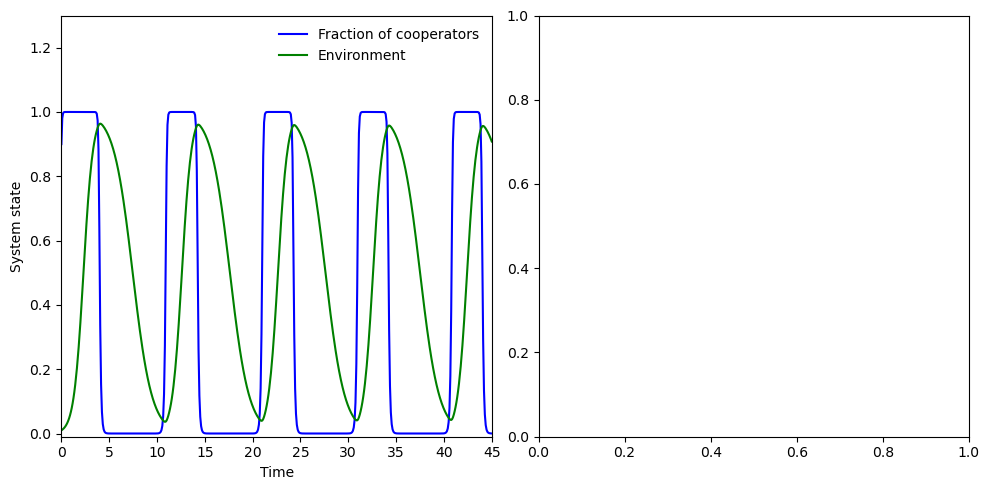

In [37]:
def reproduce_figure_2():
    # Parameters from Weitz et al. 2016
    epsilon = 0.1
    theta = 2.0
    R, S, T, P = 3.0, 0.0, 5.0, 1.0

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # --- LEFT PANEL: Time Series ---
    # Matches the smooth curves in Fig 2A
    sol = solve_ivp(dynamics_symmetric, (0, 45), [0.9, 0.01], 
                    method="BDF",
                    t_eval=np.linspace(0, 45, 500),
                    args=(epsilon, theta, R, S, T, P),
                    max_step=0.10, rtol=1e-7, atol=1e-11) #7, 11
    
    ax = axes[0]
    ax.plot(sol.t, sol.y[0], 'b-', label='Fraction of cooperators')
    ax.plot(sol.t, sol.y[1], 'g-', label='Environment')
    ax.set_xlabel('Time')
    ax.set_ylabel('System state')
    ax.set_xlim(0, 45)
    ax.set_ylim(-0.01, 1.3)
    ax.legend(loc='upper right', frameon=False)
    
    plt.tight_layout()
    plt.show()

reproduce_figure_2()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def get_payoff_matrix(n, A0, A1):
    # Eq. 18: Interpolate payoff matrix A(n)
    return (1 - n) * A0 + n * A1

def get_fast_parameters(n, A0, A1):
    # Calculate fitness difference r1 - r2 = ax + b
    A = get_payoff_matrix(n, A0, A1)
    
    R, S = A[0, 0], A[0, 1]
    T, P = A[1, 0], A[1, 1]
    
    # Algebra derived from expanding (Rx + S(1-x)) - (Tx + P(1-x))
    # Intercept (b) = S - P
    b = S - P
    # Slope (a) = (R - T) - (S - P)
    a = (R - T) - b
    
    return a, b

def fast_slow_system(t, y, epsilon, theta, A0, A1):
    x, n = y
    
    # 1. Fast Dynamics (x)
    # x' = x(1-x)(r1 - r2) -> substituted with ax + b
    a, b = get_fast_parameters(n, A0, A1)
    dxdt = x * (1 - x) * (a * x + b)
    
    # 2. Slow Dynamics (n)
    # Eq. 20
    dndt = epsilon * n * (1 - n) * (-1 + (1 + theta) * x)
    
    return [dxdt, dndt]

def get_bifurcations(A0, A1):
    """Finds intersection points of the interior manifold with boundaries."""
    bifs = []
    a0, b0 = get_fast_parameters(0, A0, A1)
    a1, b1 = get_fast_parameters(1, A0, A1)
    
    # Intersection with x=0 (where b=0)
    denom = b1 - b0
    if abs(denom) > 1e-9:
        n0 = -b0 / denom
        if 0 <= n0 <= 1: bifs.append((0, n0))
            
    # Intersection with x=1 (where a+b=0)
    denom = (a1+b1) - (a0+b0)
    if abs(denom) > 1e-9:
        n1 = -(a0+b0) / denom
        if 0 <= n1 <= 1: bifs.append((1, n1))
    return bifs


In [52]:
import numpy as np

# ============================================================================
# 3. PLOTTING HELPERS
# ============================================================================

def plot_fast_fibers(ax, A0, A1):
    def plot_arrow(x, n):
        # Determine flow direction along the fiber
        # The direction is determined by the sign of x' = x(1-x)(ax + b).
        # Since x(1-x) > 0 in the interior, the sign depends on (ax + b).
        a, b = get_fast_parameters(n, A0, A1)
        dx = a * x + b
        marker = '>' if dx > 0 else '<'
        ax.plot(x, n, marker=marker, color='black', markersize=6)

    # Define vertical levels (n) to plot the fibers
    n_levels = np.linspace(0, 1.0, 11)

    for n in n_levels:
        # Draw the fiber line (fixed n, varying x)
        ax.plot([0, 1], [n, n], color='blue', lw=1, alpha=0.8)
        plot_arrow(0.25, n)
        plot_arrow(0.75, n)

def plot_boundary_manifolds(ax, A0, A1):
    """
    Plots vertical boundaries x=0 and x=1.
    Uses 'np.nan' to break lines instead of masked arrays.
    """
    n = np.linspace(0, 1, 500)
    
    # 1. Vectorized Parameter Calculation
    params = [get_fast_parameters(val, A0, A1) for val in n]
    a = np.array([p[0] for p in params])
    b = np.array([p[1] for p in params])

    # 2. Define a helper to plot one boundary
    def plot_line(x_const, is_stable, arrow_dy):
        # Create copies of 'n' for plotting
        n_stable = n.copy()
        n_unstable = n.copy()
        
        # Insert NaNs where the condition is NOT met
        # Matplotlib will skip drawing where data is NaN
        n_stable[~is_stable] = np.nan   # Hide unstable parts
        n_unstable[is_stable] = np.nan  # Hide stable parts
        
        # Plot the lines
        x_vals = np.full_like(n, x_const)
        ax.plot(x_vals, n_stable, 'k-', lw=2)
        ax.plot(x_vals, n_unstable, 'k--', lw=2)
        
        # Add Arrows
        for y in [0.2, 0.5, 0.8]:
            ax.arrow(x_const, y, 0, arrow_dy, head_width=0.035, 
                     color='k', length_includes_head=True)

    # --- Execute ---
    
    # x=0: Stable if b < 0. Arrows Down.
    plot_line(x_const=0, is_stable=(b < 0), arrow_dy=-0.001)

    # x=1: Stable if a+b > 0. Arrows Up.
    plot_line(x_const=1, is_stable=(a + b > 0), arrow_dy=0.001)


def plot_interior_manifold(ax, theta, A0, A1):
    """
    Plots the curved interior nullcline (x' = 0).
    Replaces errstate/masks with standard NaN filtering.
    """
    # 1. Setup Space
    n = np.linspace(0.01, 0.99, 600)
    
    # 2. Get Parameters
    params = [get_fast_parameters(val, A0, A1) for val in n]
    a = np.array([p[0] for p in params])
    b = np.array([p[1] for p in params])

    # 3. Calculate Interior Fixed Point (x*) safely
    # We create an array of NaNs first to handle the "divide by zero" case gracefully
    x_c = np.full_like(n, np.nan)
    
    # Only divide where 'a' is not zero
    safe_indices = np.abs(a) > 1e-6
    x_c[safe_indices] = -b[safe_indices] / a[safe_indices]
    
    # 4. Filter for Valid Domain [0, 1]
    # Keep only points that are physically valid numbers between 0 and 1
    valid_mask = (x_c >= 0) & (x_c <= 1) & (~np.isnan(x_c))
    
    x_plot = x_c[valid_mask]
    n_plot = n[valid_mask]
    a_plot = a[valid_mask]
    
    if len(x_plot) == 0: return

    # 5. Prepare Stable vs Unstable Lines using NaNs
    is_stable = (a_plot < 0)
    
    n_stable = n_plot.copy()
    n_stable[~is_stable] = np.nan # Hide unstable
    
    n_unstable = n_plot.copy()
    n_unstable[is_stable] = np.nan # Hide stable

    ax.plot(x_plot, n_stable,   'k-', lw=2, alpha=0.8)
    ax.plot(x_plot, n_unstable, 'k--', lw=2, alpha=0.8)

    # 6. Add Arrows (2 Arrows: Left and Right)
    idx_left = int(len(x_plot) * 0.35)
    idx_right = int(len(x_plot) * 0.80)
    
    arrow_indices = [max(1, idx_left), min(len(x_plot)-2, idx_right)]
    
    for i in arrow_indices:
        x_p, n_p = x_plot[i], n_plot[i]
        
        dx = x_plot[i+1] - x_plot[i-1]
        dn = n_plot[i+1] - n_plot[i-1]
        
        slow_val = -1 + (1 + theta) * x_p
        
        if slow_val < 0:
            dx, dn = -dx, -dn
            
        ax.arrow(x_p, n_p, dx*0.001, dn*0.001, shape='full', lw=0, 
                 length_includes_head=True, head_width=0.035, color='k', zorder=20)

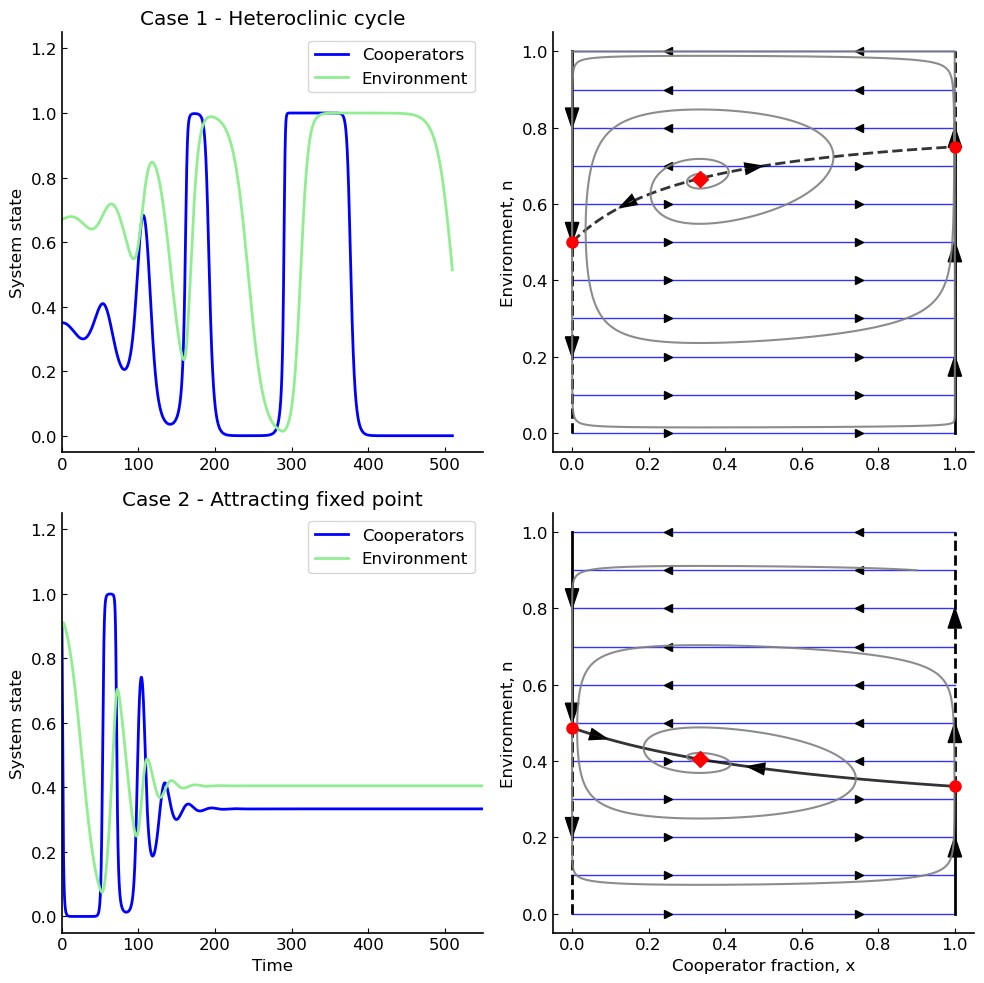

In [54]:
def reproduce_figure_3():
    
    # Shared Parameters
    epsilon = 0.1
    theta = 2.0
    
    # --- Case 1: Heteroclinic Cycle ---
    A0_het = np.array([[3.5, 1.0], [2.0, 0.75]])
    A1_het = np.array([[4.0, 1.0], [4.5, 1.25]])
    y0_het = [0.35, 0.67] # Initial condition
    
    sol_het = solve_ivp(fast_slow_system, (0, 510), y0_het, 
                        args=(epsilon, theta, A0_het, A1_het), 
                        rtol=1e-10, atol=1e-13, max_step=0.01)

    # --- Case 2: Attracting Fixed Point ---
    A0_fix = np.array([[3.5, 1.0], [2.0, 0.05]])
    A1_fix = np.array([[4.0, 1.0], [7.0, 2.0]])
    y0_fix = [0.9, 0.9] # Initial condition
    
    sol_fix = solve_ivp(fast_slow_system, (0, 550), y0_fix, 
                        args=(epsilon, theta, A0_fix, A1_fix), 
                        rtol=1e-10, atol=1e-13, max_step=0.1)

    # --- Plotting ---
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    # [Top Left] Case 1 Time Series
    axes[0,0].plot(sol_het.t, sol_het.y[0], label='Cooperators', color="blue")
    axes[0,0].plot(sol_het.t, sol_het.y[1], label='Environment', color="lightgreen")
    axes[0,0].set_title('Case 1 - Heteroclinic cycle')
    axes[0,0].set_ylabel('System state')
    axes[0,0].set_xlim(0, 550)
    axes[0,0].set_ylim(-0.05, 1.25)
    axes[0,0].legend()

    # [Top Right] Case 1 Phase Plane
    ax1 = axes[0,1]
    plot_fast_fibers(ax1, A0_het, A1_het)
    plot_boundary_manifolds(ax1, A0_het, A1_het)
    plot_interior_manifold(ax1, theta, A0_het, A1_het)
    
    # Markers (Bifurcations & Repeller)
    for bx, bn in get_bifurcations(A0_het, A1_het):
        ax1.plot(bx, bn, 'ro', zorder=20, markersize=8)
    
    # Repeller (Approx location derived from theta)
    ax1.plot(1/(1+theta), 2/3, marker='D', color='red', markersize=8, zorder=30)
    
    # Trajectory
    ax1.plot(sol_het.y[0], sol_het.y[1], color='grey', lw=1.5, alpha=0.9)
    ax1.set_xlim(-0.05, 1.05); ax1.set_ylim(-0.05, 1.05)
    ax1.set_ylabel('Environment, n')

    # [Bottom Left] Case 2 Time Series
    axes[1,0].plot(sol_fix.t, sol_fix.y[0], label='Cooperators', color="blue")
    axes[1,0].plot(sol_fix.t, sol_fix.y[1], label='Environment', color="lightgreen")
    axes[1,0].set_title('Case 2 - Attracting fixed point')
    axes[1,0].set_ylabel('System state')
    axes[1,0].set_xlabel('Time')
    axes[1,0].set_xlim(0, 550)
    axes[1,0].set_ylim(-0.05, 1.25)
    axes[1,0].legend()

    # [Bottom Right] Case 2 Phase Plane
    ax2 = axes[1,1]
    plot_fast_fibers(ax2, A0_fix, A1_fix)
    plot_boundary_manifolds(ax2, A0_fix, A1_fix)
    plot_interior_manifold(ax2, theta, A0_fix, A1_fix)
    
    # Markers (Bifurcations & Attractor)
    for bx, bn in get_bifurcations(A0_fix, A1_fix):
        ax2.plot(bx, bn, 'ro', zorder=20, markersize=8)
        
    ax2.plot(sol_fix.y[0][-1], sol_fix.y[1][-1], marker='D', color='red', 
             markersize=8, zorder=30)
    
    # Trajectory
    ax2.plot(sol_fix.y[0], sol_fix.y[1], color='grey', lw=1.5, alpha=0.9)
    ax2.set_xlim(-0.05, 1.05); ax2.set_ylim(-0.05, 1.05)
    ax2.set_xlabel('Cooperator fraction, x')
    ax2.set_ylabel('Environment, n')

    plt.tight_layout()
    plt.show()

reproduce_figure_3()


startpunten niet gelijk en paper zegt niet wat startpunten zijn.

<>:47: SyntaxWarning: invalid escape sequence '\e'
<>:58: SyntaxWarning: invalid escape sequence '\e'
<>:47: SyntaxWarning: invalid escape sequence '\e'
<>:58: SyntaxWarning: invalid escape sequence '\e'
C:\Users\rayan\AppData\Local\Temp\ipykernel_1796\755575152.py:47: SyntaxWarning: invalid escape sequence '\e'
  ax_left.text(0.03, 0.08, f'$\epsilon = {eps}$', transform=ax_left.transAxes, fontsize=11)
C:\Users\rayan\AppData\Local\Temp\ipykernel_1796\755575152.py:58: SyntaxWarning: invalid escape sequence '\e'
  ax_right.text(0.03, 0.08, f'$\epsilon = {eps}$', transform=ax_right.transAxes, fontsize=11)


Generating Figure 4...


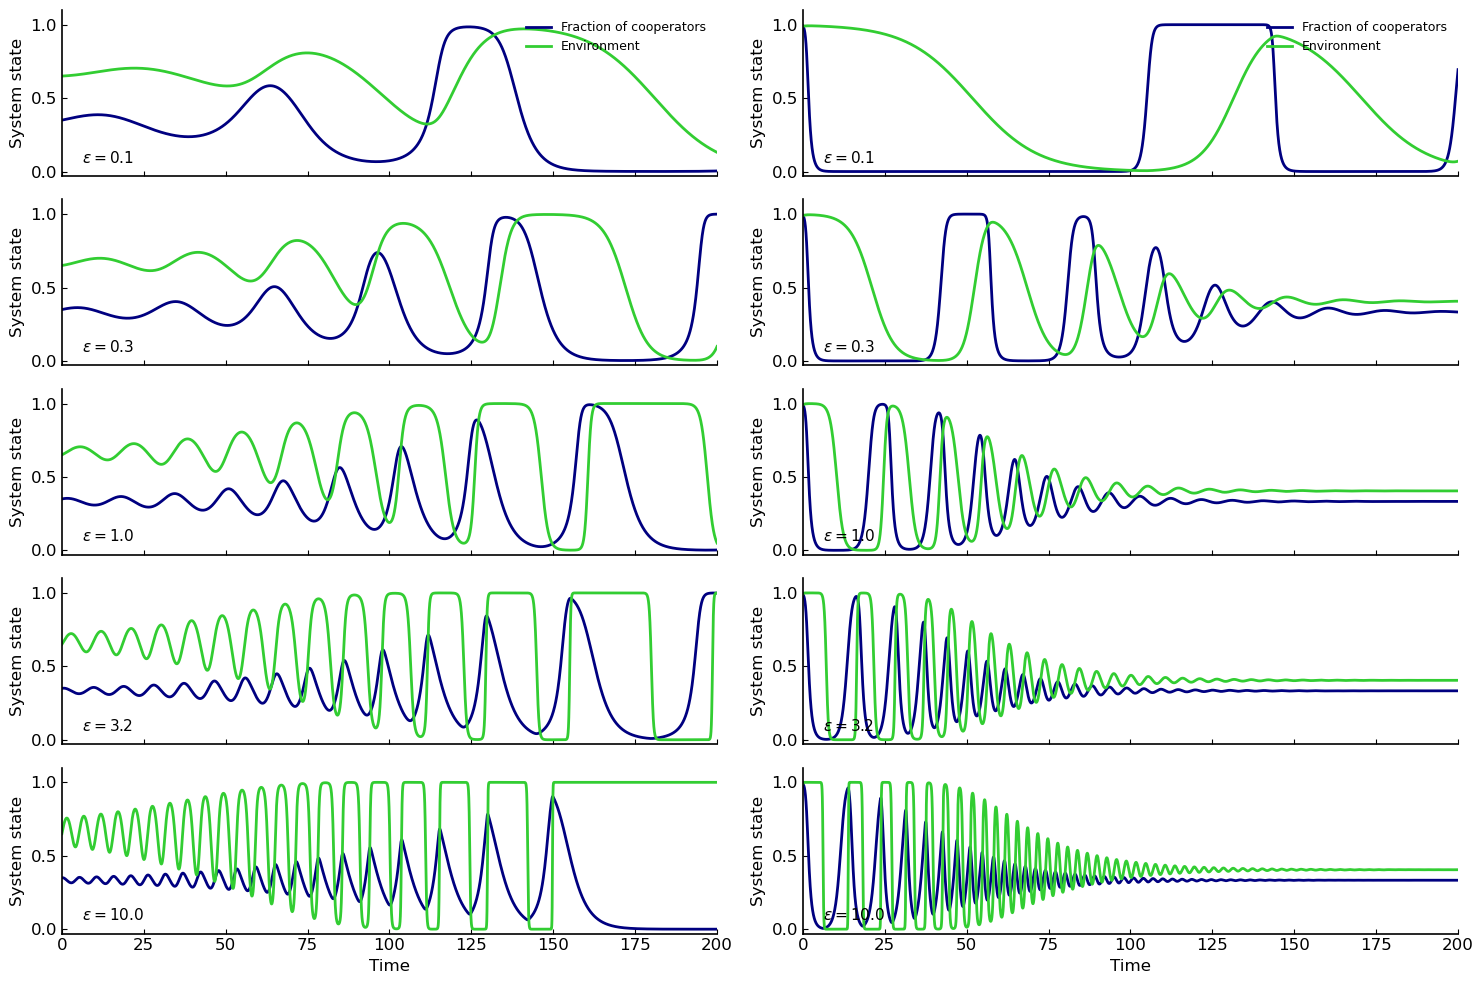

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
# ============================================================================
# 2. FIGURE 4 REPRODUCTION
# ============================================================================

def reproduce_figure_4():
    print("Generating Figure 4...")
    
    # --- Parameters ---
    epsilon_values = [0.1, 0.3, 1.0, 3.2, 10.0]  # Rows of the plot
    theta = 2.0
    t_span = (0, 200)  # Time duration
    
    # --- Matrices ---
    # Left Column: Heteroclinic Cycle (Oscillating)
    A0_het = np.array([[3.5, 1.0], [2.0, 0.75]])
    A1_het = np.array([[4.0, 1.0], [4.5, 1.25]])
    y0_het = [0.35, 0.65] 
    
    # Right Column: Interior Fixed Point (Stable)
    A0_fix = np.array([[3.5, 1.0], [2.0, 0.05]])
    A1_fix = np.array([[4.0, 1.0], [7.0, 2.0]])
    y0_fix = [0.99, 0.99]

    # --- Plot Setup ---
    # 5 Rows, 2 Columns
    fig, axes = plt.subplots(len(epsilon_values), 2, figsize=(15, 10), sharex=True)
    
    # Colors matching the paper
    color_coop = '#000080'  # Navy Blue
    color_env = '#32CD32'   # Lime Green

    for i, eps in enumerate(epsilon_values):
        
        # --- Left Column: Heteroclinic ---
        sol_het = solve_ivp(fast_slow_system, t_span, y0_het,
                            args=(eps, theta, A0_het, A1_het),
                            rtol=1e-10, atol=1e-13, max_step=0.1)
        
        ax_left = axes[i, 0]
        ax_left.plot(sol_het.t, sol_het.y[0], color=color_coop, lw=2)
        ax_left.plot(sol_het.t, sol_het.y[1], color=color_env, lw=2)
        
        # Text Label (e.g., "epsilon = 0.1")
        ax_left.text(0.03, 0.08, f'$\epsilon = {eps}$', transform=ax_left.transAxes, fontsize=11)
        
        # --- Right Column: Fixed Point ---
        sol_fix = solve_ivp(fast_slow_system, t_span, y0_fix,
                            args=(eps, theta, A0_fix, A1_fix),
                            rtol=1e-10, atol=1e-13, max_step=0.1)
        
        ax_right = axes[i, 1]
        ax_right.plot(sol_fix.t, sol_fix.y[0], color=color_coop, lw=2)
        ax_right.plot(sol_fix.t, sol_fix.y[1], color=color_env, lw=2)
        
        ax_right.text(0.03, 0.08, f'$\epsilon = {eps}$', transform=ax_right.transAxes, fontsize=11)

        # --- Formatting for both columns ---
        for ax in [ax_left, ax_right]:
            ax.set_ylim(-0.03, 1.1)
            ax.set_ylabel('System state')
            
            # Add the requested space left of 0 and right of 200
            ax.set_xlim(0, 200)
            
            # Hide x-ticks for all but the bottom row
            if i < len(epsilon_values) - 1:
                ax.tick_params(labelbottom=False)

    # --- Final Touches ---
    # Legends on top row only
    axes[0, 0].legend(['Fraction of cooperators', 'Environment'], 
                      loc='upper right', frameon=False, fontsize=9)
    axes[0, 1].legend(['Fraction of cooperators', 'Environment'], 
                      loc='upper right', frameon=False, fontsize=9)

    # X-labels on bottom row only
    axes[-1, 0].set_xlabel('Time')
    axes[-1, 1].set_xlabel('Time')

    plt.tight_layout()
    plt.show()

reproduce_figure_4()